In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.utils.data as data
import torchvision
import torch.nn.functional as F
import torchvision.transforms as T
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Get the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Get the data set
OUTPUT_DIR = '/content/drive/MyDrive/audio-images/'
!ls '/content/drive/MyDrive/audio-images/'

# Hyperparameters
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
BATCH_SIZE = 32
num_classes = 10




class_0  class_2  class_4  class_6  class_8
class_1  class_3  class_5  class_7  class_9


In [ ]:
!pwd 

/content


In [ ]:
train_dataset = torchvision.datasets.ImageFolder(
    OUTPUT_DIR,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
    ]),
    target_transform=None,
    is_valid_file=None
)

In [ ]:
train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_size, valid_size])
# Create the dataloaders
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)
valid_dataloader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

In [ ]:
def prepare(ds, augment=False):
    # Define our one transformation
    rescale = T.Compose([T.ToTensor(), T.Normalize((0.5,), (0.5,))])
    flip_and_rotate = T.Compose([T.RandomHorizontalFlip(), T.RandomRotation(30)])
    
    # Apply rescale to both datasets and augmentation only to training
    if augment:
        ds =torchvision.datasets.ImageFolder( OUTPUT_DIR, transform=flip_and_rotate)
    ds = torchvision.datasets.ImageFolder(OUTPUT_DIR, transform=rescale)
    return ds

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = Net().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
total_step = len(train_dataloader)
loss_list = []
acc_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_dataloader):
        images = images.to(device)
        labels = torch.from_numpy(np.array(labels)).to(device)
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)
        if (i + 1) % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

Epoch [1/10], Step [10/60], Loss: 2.0796, Accuracy: 21.88%
Epoch [1/10], Step [20/60], Loss: 1.7700, Accuracy: 43.75%
Epoch [1/10], Step [30/60], Loss: 1.2546, Accuracy: 65.62%
Epoch [1/10], Step [40/60], Loss: 0.7843, Accuracy: 75.00%
Epoch [1/10], Step [50/60], Loss: 0.9430, Accuracy: 71.88%
Epoch [1/10], Step [60/60], Loss: 0.4104, Accuracy: 84.38%
Epoch [2/10], Step [10/60], Loss: 0.3099, Accuracy: 93.75%
Epoch [2/10], Step [20/60], Loss: 0.1721, Accuracy: 100.00%
Epoch [2/10], Step [30/60], Loss: 0.2943, Accuracy: 90.62%
Epoch [2/10], Step [40/60], Loss: 0.2184, Accuracy: 93.75%
Epoch [2/10], Step [50/60], Loss: 0.2673, Accuracy: 90.62%
Epoch [2/10], Step [60/60], Loss: 0.1250, Accuracy: 96.88%
Epoch [3/10], Step [10/60], Loss: 0.2637, Accuracy: 90.62%
Epoch [3/10], Step [20/60], Loss: 0.2702, Accuracy: 90.62%
Epoch [3/10], Step [30/60], Loss: 0.2313, Accuracy: 84.38%
Epoch [3/10], Step [40/60], Loss: 0.0984, Accuracy: 93.75%
Epoch [3/10], Step [50/60], Loss: 0.0189, Accuracy: 100

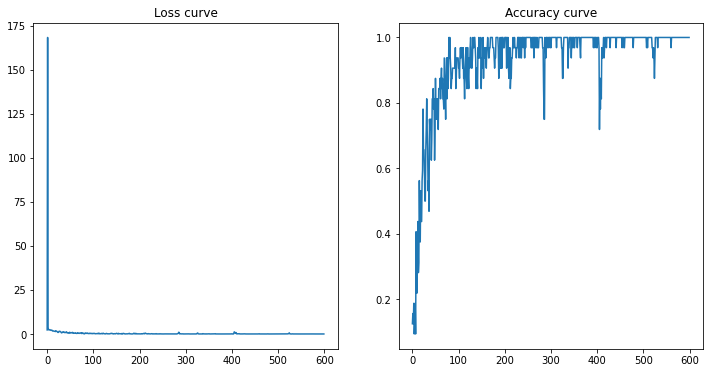

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(loss_list)
plt.title("Loss curve")
plt.subplot(1, 2, 2)
plt.plot(acc_list)
plt.title("Accuracy curve")
plt.show()


In [ ]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in valid_dataloader:
        images = images.to(device)
        labels = torch.from_numpy(np.array(labels)).to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the {} test images: {} %'.format(total, (correct / total) * 100))

Test Accuracy of the model on the 480 test images: 96.25 %


In [ ]:
!ls '/content/drive/MyDrive/audio-images/class_0/'
test_dataset = torchvision.datasets.ImageFolder(
    '/content/drive/MyDrive/audio-images/',
    transform=torchvision.transforms.Compose([
        torchvision.transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
    ]),
    target_transform=None,
    is_valid_file=None
)
test_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)
images, labels = next(iter(test_dataloader))
with torch.no_grad():
    out = model(images)
    _, predicted = torch.max(out.data, 1)
    print("Predicted class:", predicted)


0_george_0.png	  0_jackson_32.png  0_nicolas_0.png   0_theo_32.png
0_george_10.png   0_jackson_33.png  0_nicolas_10.png  0_theo_33.png
0_george_11.png   0_jackson_34.png  0_nicolas_11.png  0_theo_34.png
0_george_12.png   0_jackson_35.png  0_nicolas_12.png  0_theo_35.png
0_george_13.png   0_jackson_36.png  0_nicolas_13.png  0_theo_36.png
0_george_14.png   0_jackson_37.png  0_nicolas_14.png  0_theo_37.png
0_george_15.png   0_jackson_38.png  0_nicolas_15.png  0_theo_38.png
0_george_16.png   0_jackson_39.png  0_nicolas_16.png  0_theo_39.png
0_george_17.png   0_jackson_3.png   0_nicolas_17.png  0_theo_3.png
0_george_18.png   0_jackson_40.png  0_nicolas_18.png  0_theo_40.png
0_george_19.png   0_jackson_41.png  0_nicolas_19.png  0_theo_41.png
0_george_1.png	  0_jackson_42.png  0_nicolas_1.png   0_theo_42.png
0_george_20.png   0_jackson_43.png  0_nicolas_20.png  0_theo_43.png
0_george_21.png   0_jackson_44.png  0_nicolas_21.png  0_theo_44.png
0_george_22.png   0_jackson_45.png  0_nicolas_22.pn

In [ ]:
!pwd 

/content
